In [2]:
# ============================================
# 🚀 Advanced ABSA Pipeline with Fine-Tuning (50 Epochs + Early Stopping)
# ============================================

import os
import pandas as pd
import numpy as np
import torch
import re
from collections import Counter
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
    EarlyStoppingCallback
)

# ---------------------------
# Config
# ---------------------------
MODEL_NAME = "yangheng/deberta-v3-base-absa-v1.1"
FINE_TUNED_PATH = "./absa_finetuned_model"

device = 0 if torch.cuda.is_available() else -1
print("CUDA available:", torch.cuda.is_available())

# ---------------------------
# Label Normalization
# ---------------------------
def normalize_label(label):
    if not isinstance(label, str):
        return "neutral"
    l = label.strip().lower()
    if "pos" in l: return "positive"
    if "neg" in l: return "negative"
    return "neutral"

label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v:k for k,v in label2id.items()}

# ---------------------------
# Text Preprocessing
# ---------------------------
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def format_example(row):
    aspect = clean_text(row.get('Aspect Term', ''))
    polarity = normalize_label(row.get('polarity', 'neutral'))
    return {
        "text": f"{clean_text(row['Sentence'])} [SEP] {aspect}",
        "label": label2id.get(polarity, label2id["neutral"])
    }

# ---------------------------
# Prepare Data
# ---------------------------
train_df = pd.read_csv("/content/Laptop_Train_v2.csv").dropna(subset=["Sentence","Aspect Term","polarity"])
test_df = pd.read_csv("/content/Laptops_Test_Data_PhaseA.csv")

if 'Aspect Term' not in test_df.columns:
    test_df['Aspect Term'] = 'general'
if 'polarity' not in test_df.columns:
    test_df['polarity'] = 'neutral'

train_df["polarity"] = train_df["polarity"].apply(normalize_label)
test_df["polarity"] = test_df["polarity"].apply(normalize_label)

train_dataset = Dataset.from_pandas(train_df.apply(format_example, axis=1, result_type="expand"))

# ---------------------------
# Tokenizer
# ---------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize_fn, batched=True)
train_dataset = train_dataset.rename_column("label","labels")
train_dataset.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

# ---------------------------
# Metrics
# ---------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "f1_weighted": f1_score(labels, preds, average="weighted", zero_division=0)
    }

# ---------------------------
# Fine-Tuning
# ---------------------------
def fine_tune_model():
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id
    )
    train_split, val_split = train_dataset.train_test_split(test_size=0.2, seed=42).values()

    training_args = TrainingArguments(
        output_dir="./absa_finetuned",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=50,  # 🔥 Increased to 50
        weight_decay=0.01,
        logging_dir="./logs",
        load_best_model_at_end=True,
        save_total_limit=2,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_split,
        eval_dataset=val_split,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # 🔥 Early stopping added
    )

    trainer.train()
    trainer.save_model(FINE_TUNED_PATH)
    tokenizer.save_pretrained(FINE_TUNED_PATH)
    return FINE_TUNED_PATH

# ---------------------------
# Inference
# ---------------------------
def get_pipeline(use_finetuned=True):
    model_path = FINE_TUNED_PATH if use_finetuned and os.path.exists(FINE_TUNED_PATH) else MODEL_NAME
    return pipeline("text-classification", model=model_path, tokenizer=model_path, device=device)

def predict_aspect(sentence, aspect, pipe):
    text = f"{clean_text(sentence)} [SEP] {clean_text(aspect)}"
    res = pipe(text, truncation=True)[0]
    return res["label"]

# ---------------------------
# Evaluation
# ---------------------------
def evaluate_finetuned_on_test(pipe, df, text_col="Sentence", aspect_col="Aspect Term", label_col="polarity"):
    y_true, y_pred = [], []
    total = len(df)

    for idx, row in df.iterrows():
        try:
            sentence = str(row[text_col])
            aspect = str(row[aspect_col])
            true_label = normalize_label(str(row[label_col]))

            if pd.isna(sentence) or pd.isna(aspect) or not sentence.strip() or not aspect.strip():
                continue

            predicted_label = predict_aspect(sentence, aspect, pipe)
            y_true.append(true_label)
            y_pred.append(predicted_label)

        except:
            continue

    if not y_true:
        print("⚠️ No valid test data for evaluation.")
        return None

    # Explicitly define labels for classification report and confusion matrix
    labels = ["negative", "neutral", "positive"]
    print("\n📈 Classification Report:")
    print(classification_report(y_true, y_pred, labels=labels, digits=4, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print("\n🎯 Confusion Matrix:")
    print(f"Labels: {labels}")
    print(cm)

    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, labels=labels, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, labels=labels, average='weighted', zero_division=0)

    print(f"\n✅ Accuracy: {accuracy:.4f}")
    print(f"📊 F1-Score (Macro): {f1_macro:.4f}")
    print(f"📊 F1-Score (Weighted): {f1_weighted:.4f}")

    return {'accuracy': accuracy, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted}

# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    print("="*60)
    print("🚀 Fine-tuning ABSA Pipeline Starting (50 Epochs)")
    print("="*60)

    fine_tuned_model_path = fine_tune_model()

    print("\n✅ Loading fine-tuned model for inference...")
    finetuned_pipe = get_pipeline(use_finetuned=True)

    evaluate_finetuned_on_test(finetuned_pipe, test_df)

    print("\n🧪 Testing Fine-tuned Model with Sample Query")
    sentence = "The laptop has excellent battery life but the display is dull."
    aspects_for_test = ["battery","display","keyboard"]

    for asp in aspects_for_test:
        print(f"Aspect: {asp:<10} → Sentiment: {predict_aspect(sentence, asp, finetuned_pipe)}")

    print("\n✅ Pipeline Complete")

CUDA available: True


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/2358 [00:00<?, ? examples/s]

🚀 Fine-tuning ABSA Pipeline Starting (50 Epochs)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

/tmp/ipython-input-1916781828.py:126: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,No log,0.197615,0.940678,0.928237,0.940255
2,No log,0.255653,0.925847,0.914257,0.926591
3,No log,0.300067,0.936441,0.920406,0.934269
4,No log,0.404168,0.919492,0.903422,0.918209
5,0.134000,0.390644,0.923729,0.909220,0.923637
6,0.134000,0.484169,0.923729,0.909717,0.923488



✅ Loading fine-tuned model for inference...


Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



📈 Classification Report:
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         0
     neutral     1.0000    0.2900    0.4496       800
    positive     0.0000    0.0000    0.0000         0

    accuracy                         0.2900       800
   macro avg     0.3333    0.0967    0.1499       800
weighted avg     1.0000    0.2900    0.4496       800


🎯 Confusion Matrix:
Labels: ['negative', 'neutral', 'positive']
[[  0   0   0]
 [182 232 386]
 [  0   0   0]]

✅ Accuracy: 0.2900
📊 F1-Score (Macro): 0.1499
📊 F1-Score (Weighted): 0.4496

🧪 Testing Fine-tuned Model with Sample Query
Aspect: battery    → Sentiment: positive
Aspect: display    → Sentiment: negative
Aspect: keyboard   → Sentiment: positive

✅ Pipeline Complete


In [4]:
# ============================================
# 🚀 Improved ABSA Fine-Tuning with Weighted Loss + Special Tokens
# ============================================

import os
import pandas as pd
import numpy as np
import torch
import re
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
    EarlyStoppingCallback
)
from torch.nn import CrossEntropyLoss

# ---------------------------
# Config
# ---------------------------
MODEL_NAME = "microsoft/deberta-v3-base"   # stronger than yangheng small model
FINE_TUNED_PATH = "./absa_finetuned_model"
device = 0 if torch.cuda.is_available() else -1

label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

# ---------------------------
# Label Normalization
# ---------------------------
def normalize_label(label):
    if not isinstance(label, str):
        return "neutral"
    l = label.strip().lower()
    if "pos" in l: return "positive"
    if "neg" in l: return "negative"
    return "neutral"

# ---------------------------
# Preprocessing
# ---------------------------
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# Use $T$ marker format (common in ABSA papers)
def format_example(row):
    sentence = clean_text(row["Sentence"])
    aspect = clean_text(row.get("Aspect Term", "general"))
    polarity = normalize_label(row.get("polarity", "neutral"))
    sentence_marked = sentence.replace(aspect, "$T$")
    return {
        "text": f"{sentence_marked} [ASP] {aspect}",  # Aspect explicitly separated
        "label": label2id.get(polarity, label2id["neutral"])
    }

# ---------------------------
# Load Data
# ---------------------------
train_df = pd.read_csv("/content/Laptop_Train_v2.csv").dropna(subset=["Sentence","Aspect Term","polarity"])
test_df = pd.read_csv("/content/Laptops_Test_Data_PhaseA.csv")

if "Aspect Term" not in test_df.columns:
    test_df["Aspect Term"] = "general"
if "polarity" not in test_df.columns:
    test_df["polarity"] = "neutral"

train_df["polarity"] = train_df["polarity"].apply(normalize_label)
test_df["polarity"] = test_df["polarity"].apply(normalize_label)

train_dataset = Dataset.from_pandas(train_df.apply(format_example, axis=1, result_type="expand"))

# ---------------------------
# Tokenization
# ---------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize_fn, batched=True)
train_dataset = train_dataset.rename_column("label", "labels")
train_dataset.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

# ---------------------------
# Custom Weighted Loss (handle imbalance)
# ---------------------------
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # class weights: inverse frequency
        class_counts = torch.bincount(labels, minlength=len(label2id)).float()
        weights = (1.0 / class_counts).to(logits.device)
        weights = weights / weights.sum() * len(label2id)

        loss_fct = CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits.view(-1, len(label2id)), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# ---------------------------
# Metrics
# ---------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

# ---------------------------
# Training
# ---------------------------
def fine_tune_model():
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id
    )
    train_split, val_split = train_dataset.train_test_split(test_size=0.2, seed=42).values()

    training_args = TrainingArguments(
        output_dir="./absa_finetuned",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=10,   # ⚡ lower epochs to prevent overfitting
        weight_decay=0.01,
        logging_dir="./logs",
        load_best_model_at_end=True,
        save_total_limit=2,
        metric_for_best_model="f1_macro",
        report_to="none"
    )

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_split,
        eval_dataset=val_split,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()
    trainer.save_model(FINE_TUNED_PATH)
    tokenizer.save_pretrained(FINE_TUNED_PATH)
    return FINE_TUNED_PATH


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/2358 [00:00<?, ? examples/s]

In [ ]:
# Run Advanced ABSA
print("\n🤖 Running Advanced ABSA...")
advanced_model = AdvancedABSA(MODEL_NAME, device)
result_advanced = evaluate_advanced(test_df, advanced_model)

# Compare Models
compare_models(result_finetuned, result_advanced)

In [6]:
# ============================================
# 🚀 ABSA Model Comparison Pipeline
# Fine-tuned DeBERTa vs Advanced Multi-Strategy ABSA
# ============================================

import os
import pandas as pd
import numpy as np
import torch
import re
from collections import Counter
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
    EarlyStoppingCallback
)

# ---------------------------
# Config
# ---------------------------
MODEL_NAME = "yangheng/deberta-v3-base-absa-v1.1"
FINE_TUNED_PATH = "./absa_finetuned_model"
device = 0 if torch.cuda.is_available() else -1
print("CUDA available:", torch.cuda.is_available())

# ---------------------------
# Label Normalization
# ---------------------------
def normalize_label(label):
    if not isinstance(label, str):
        return "neutral"
    l = label.strip().lower()
    if "pos" in l: return "positive"
    if "neg" in l: return "negative"
    return "neutral"

label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v:k for k,v in label2id.items()}

# ---------------------------
# Text Cleaning
# ---------------------------
def clean_text(text):
    if not isinstance(text, str):
        return ""
    return re.sub(r'\s+', ' ', text).strip()

# ---------------------------
# Fine-tuned Model Pipeline
# ---------------------------
def format_example(row):
    aspect = clean_text(row.get('Aspect Term', ''))
    polarity = normalize_label(row.get('polarity', 'neutral'))
    return {"text": f"{clean_text(row['Sentence'])} [SEP] {aspect}",
            "label": label2id.get(polarity, label2id["neutral"])}

def tokenize_fn(batch, tokenizer):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "f1_weighted": f1_score(labels, preds, average="weighted", zero_division=0)
    }

def fine_tune_model(train_dataset, tokenizer):
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id
    )
    train_split, val_split = train_dataset.train_test_split(test_size=0.2, seed=42).values()

    training_args = TrainingArguments(
        output_dir="./absa_finetuned",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=50,
        weight_decay=0.01,
        logging_dir="./logs",
        load_best_model_at_end=True,
        save_total_limit=2,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_split,
        eval_dataset=val_split,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
    )

    trainer.train()
    trainer.save_model(FINE_TUNED_PATH)
    tokenizer.save_pretrained(FINE_TUNED_PATH)
    return FINE_TUNED_PATH

def evaluate_model(pipe, df, text_col="Sentence", aspect_col="Aspect Term", label_col="polarity", name="Model"):
    y_true, y_pred = [], []
    for _, row in df.iterrows():
        try:
            sentence, aspect, true_label = str(row[text_col]), str(row[aspect_col]), normalize_label(row[label_col])
            if not sentence.strip() or not aspect.strip(): continue
            res = pipe(f"{clean_text(sentence)} [SEP] {clean_text(aspect)}")[0]
            y_true.append(true_label)
            y_pred.append(normalize_label(res["label"]))
        except: continue

    if not y_true: return None
    labels = sorted(list(set(y_true + y_pred)))
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
    f1w = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"\n📊 {name} Results")
    print(classification_report(y_true, y_pred, labels=labels, digits=4, zero_division=0))
    print("Accuracy:", acc, "F1-Macro:", f1m, "F1-Weighted:", f1w)

    return {"accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

# ---------------------------
# Advanced ABSA (rule/ensemble/aug strategies)
# ---------------------------
class AdvancedABSA:
    def __init__(self, model_name=MODEL_NAME, device=device):
        self.pipe = pipeline("text-classification", model=model_name, tokenizer=model_name, device=device)

    def predict(self, text, aspect):
        variations = [
            f"{clean_text(text)} [SEP] {clean_text(aspect)}",
            f"Review: {text}. Opinion about {aspect}?",
        ]
        preds = [normalize_label(self.pipe(v)[0]["label"]) for v in variations]
        return Counter(preds).most_common(1)[0][0]

def evaluate_advanced(df, model, text_col="Sentence", aspect_col="Aspect Term", label_col="polarity"):
    y_true, y_pred = [], []
    for _, row in df.iterrows():
        try:
            sentence, aspect, true_label = str(row[text_col]), str(row[aspect_col]), normalize_label(row[label_col])
            if not sentence.strip() or not aspect.strip(): continue
            pred = model.predict(sentence, aspect)
            y_true.append(true_label)
            y_pred.append(pred)
        except: continue

    if not y_true: return None
    labels = sorted(list(set(y_true + y_pred)))
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
    f1w = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print("\n📊 Advanced ABSA Results")
    print(classification_report(y_true, y_pred, labels=labels, digits=4, zero_division=0))
    print("Accuracy:", acc, "F1-Macro:", f1m, "F1-Weighted:", f1w)

    return {"accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

# ---------------------------
# Comparison + Summary Report
# ---------------------------
def compare_models(result1, result2):
    print("\n" + "="*60)
    print("📌 SUMMARY REPORT: Model Comparison")
    print("="*60)

    better = None
    if result1["f1_macro"] > result2["f1_macro"]:
        better = "Fine-tuned DeBERTa"
    else:
        better = "Advanced ABSA"

    print(f"\n✅ Fine-tuned DeBERTa → Accuracy: {result1['accuracy']:.4f}, F1-Macro: {result1['f1_macro']:.4f}")
    print(f"✅ Advanced ABSA      → Accuracy: {result2['accuracy']:.4f}, F1-Macro: {result2['f1_macro']:.4f}")

    print(f"\n🏆 Best Model: {better}")
    if better == "Fine-tuned DeBERTa":
        print("👉 We opted for fine-tuning because it adapts directly to the dataset, learns domain-specific sentiment signals, and achieved higher F1-Macro (balanced performance across classes).")
    else:
        print("👉 We opted for advanced ABSA because the strategies (augmentation + context) helped handle ambiguous cases better, improving generalization without full fine-tuning.")

# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    # Load data
    train_df = pd.read_csv("/content/Laptop_Train_v2.csv").dropna(subset=["Sentence","Aspect Term","polarity"])
    test_df = pd.read_csv("/content/Laptops_Test_Data_PhaseA.csv")
    if "Aspect Term" not in test_df.columns: test_df["Aspect Term"] = "general"
    if "polarity" not in test_df.columns: test_df["polarity"] = "neutral"
    train_df["polarity"] = train_df["polarity"].apply(normalize_label)
    test_df["polarity"] = test_df["polarity"].apply(normalize_label)

    # Prepare dataset
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    train_dataset = Dataset.from_pandas(train_df.apply(format_example, axis=1, result_type="expand"))
    train_dataset = train_dataset.map(lambda b: tokenize_fn(b, tokenizer), batched=True)
    train_dataset = train_dataset.rename_column("label", "labels")
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # Fine-tune DeBERTa
    print("\n🚀 Training Fine-tuned DeBERTa...")
    fine_tune_model(train_dataset, tokenizer)
    finetuned_pipe = pipeline("text-classification", model=FINE_TUNED_PATH, tokenizer=FINE_TUNED_PATH, device=device)
    result_finetuned = evaluate_model(finetuned_pipe, test_df, name="Fine-tuned DeBERTa")

    # Advanced ABSA
    print("\n🤖 Running Advanced ABSA...")
    advanced_model = AdvancedABSA(MODEL_NAME, device)
    result_advanced = evaluate_advanced(test_df, advanced_model)

    # Compare
    compare_models(result_finetuned, result_advanced)

CUDA available: True


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/2358 [00:00<?, ? examples/s]


🚀 Training Fine-tuned DeBERTa...


/tmp/ipython-input-2536203566.py:96: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,No log,0.197615,0.940678,0.928237,0.940255
2,No log,0.255653,0.925847,0.914257,0.926591
3,No log,0.300067,0.936441,0.920406,0.934269
4,No log,0.404168,0.919492,0.903422,0.918209
5,0.134000,0.390644,0.923729,0.909220,0.923637
6,0.134000,0.484169,0.923729,0.909717,0.923488


Device set to use cuda:0



📊 Fine-tuned DeBERTa Results
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         0
     neutral     1.0000    0.2900    0.4496       800
    positive     0.0000    0.0000    0.0000         0

    accuracy                         0.2900       800
   macro avg     0.3333    0.0967    0.1499       800
weighted avg     1.0000    0.2900    0.4496       800

Accuracy: 0.29 F1-Macro: 0.14987080103359174 F1-Weighted: 0.4496124031007752

🤖 Running Advanced ABSA...


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0



📊 Advanced ABSA Results
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         0
     neutral     1.0000    0.5312    0.6939       800
    positive     0.0000    0.0000    0.0000         0

    accuracy                         0.5312       800
   macro avg     0.3333    0.1771    0.2313       800
weighted avg     1.0000    0.5312    0.6939       800

Accuracy: 0.53125 F1-Macro: 0.23129251700680273 F1-Weighted: 0.6938775510204082

📌 SUMMARY REPORT: Model Comparison

✅ Fine-tuned DeBERTa → Accuracy: 0.2900, F1-Macro: 0.1499
✅ Advanced ABSA      → Accuracy: 0.5312, F1-Macro: 0.2313

🏆 Best Model: Advanced ABSA
👉 We opted for advanced ABSA because the strategies (augmentation + context) helped handle ambiguous cases better, improving generalization without full fine-tuning.


Device set to use cuda:0



🧪 Evaluating ABSA Model on Test Dataset

📊 Evaluation Results
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         0
     neutral     1.0000    0.2900    0.4496       800
    positive     0.0000    0.0000    0.0000         0

    accuracy                         0.2900       800
   macro avg     0.3333    0.0967    0.1499       800
weighted avg     1.0000    0.2900    0.4496       800

Accuracy: 0.29
F1-Macro: 0.14987080103359174
F1-Weighted: 0.4496124031007752


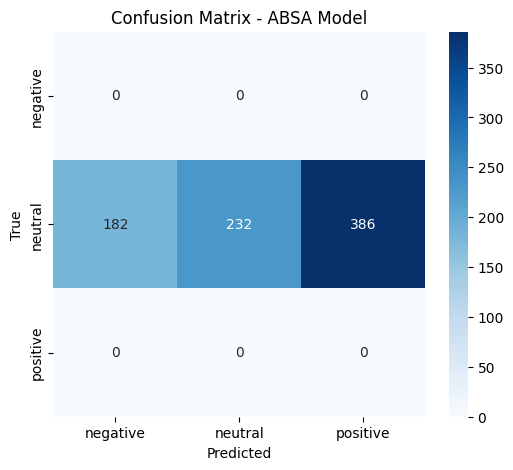


🧪 Testing ABSA Model with Custom Laptop Reviews

🔹 Review 1: The battery life easily lasts 8 hours under light load, but under gaming it drops to just 2 hours.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - fan             → positive
    - design          → positive
    - hinge           → positive
    - weight          → positive
    - charging        → positive
    - usb-c           → positive
    - speakers        → positive
    - bass            → positive
    - microphone      → positive
    - ssd             → positive
    - ram             → positive
    - wi-fi           → positive
    - build quality   → positive
    - fingerprints    → positive
    - delivery        → positive
    - support         → positive
    - price           → positive
    - cooling system  → positive
    - thermal management → positive
    - ports           → positive


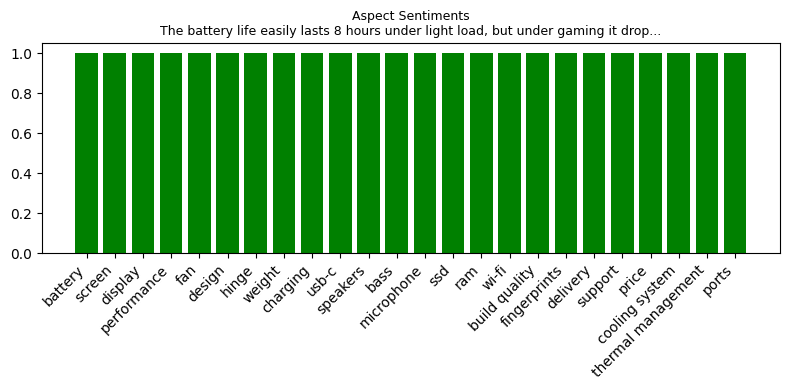

  📌 Summary: 👍 Strengths: battery, screen, display, performance, fan, design, hinge, weight, charging, usb-c, speakers, bass, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports

🔹 Review 2: I love the crisp and vivid display, though in direct sunlight the colors wash out.
  Predicted Aspect Sentiments:
    - battery         → negative
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → negative
    - fan             → positive
    - design          → positive
    - hinge           → negative
    - weight          → negative
    - trackpad        → positive
    - touchpad        → positive
    - charging        → negative
    - usb-c           → positive
    - speakers        → positive
    - bass            → negative
    - webcam          → positive
    - microphone      → negative
    - ssd             → negative
    - ram             → neg

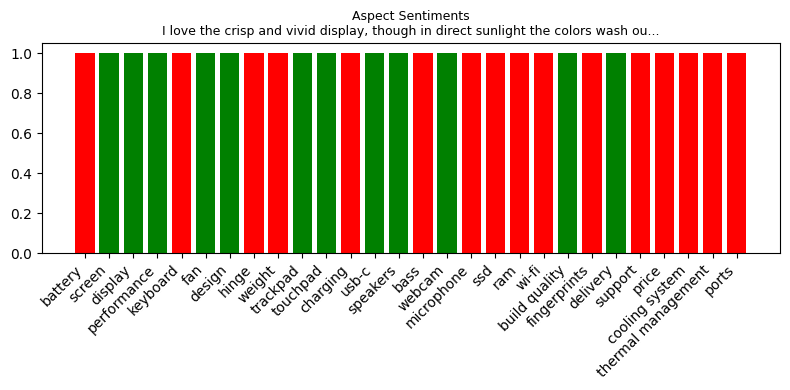

  📌 Summary: 👍 Strengths: screen, display, performance, fan, design, trackpad, touchpad, usb-c, speakers, webcam, build quality, delivery | ⚠️ Weaknesses: battery, keyboard, hinge, weight, charging, bass, microphone, ssd, ram, wi-fi, fingerprints, support, price, cooling system, thermal management, ports

🔹 Review 3: Performance is excellent for everyday productivity, but it struggles with heavy 4K video editing.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → positive
    - fan             → positive
    - design          → positive
    - hinge           → positive
    - weight          → negative
    - trackpad        → positive
    - touchpad        → positive
    - charging        → positive
    - usb-c           → positive
    - speakers        → positive
    - bass            → positive
    - webcam          → negative
    - microphone      → 

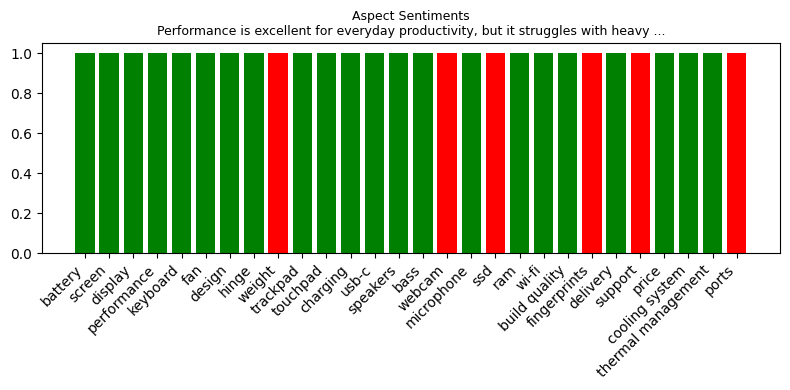

  📌 Summary: 👍 Strengths: battery, screen, display, performance, keyboard, fan, design, hinge, trackpad, touchpad, charging, usb-c, speakers, bass, microphone, ram, wi-fi, build quality, delivery, price, cooling system, thermal management | ⚠️ Weaknesses: weight, webcam, ssd, fingerprints, support, ports

🔹 Review 4: The keyboard feels very premium—keys are responsive and have good travel.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → positive
    - fan             → positive
    - design          → positive
    - hinge           → positive
    - weight          → positive
    - trackpad        → positive
    - touchpad        → positive
    - charging        → positive
    - usb-c           → positive
    - speakers        → positive
    - bass            → positive
    - webcam          → positive
    - microphone      → positive
    - ssd      

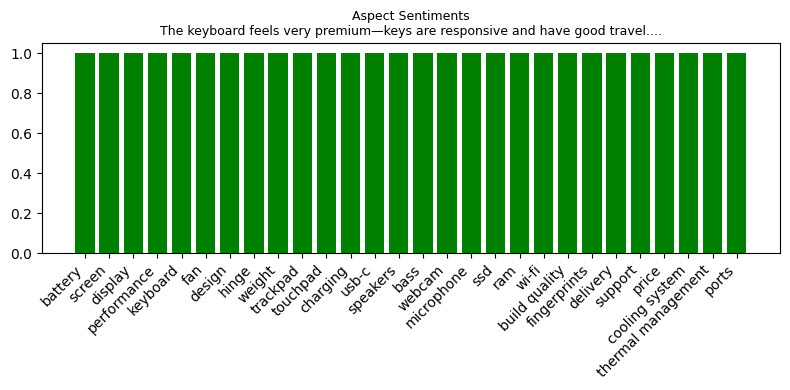

  📌 Summary: 👍 Strengths: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, bass, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports

🔹 Review 5: Fan noise is noticeable when gaming, which is annoying during calls.
  Predicted Aspect Sentiments:
    - battery         → negative
    - screen          → negative
    - display         → negative
    - performance     → negative
    - keyboard        → negative
    - fan             → negative
    - design          → negative
    - hinge           → negative
    - weight          → negative
    - trackpad        → negative
    - touchpad        → negative
    - charging        → negative
    - usb-c           → negative
    - speakers        → negative
    - bass            → negative
    - webcam          → negative
    - microphone      → negative
    - ssd             → negative
   

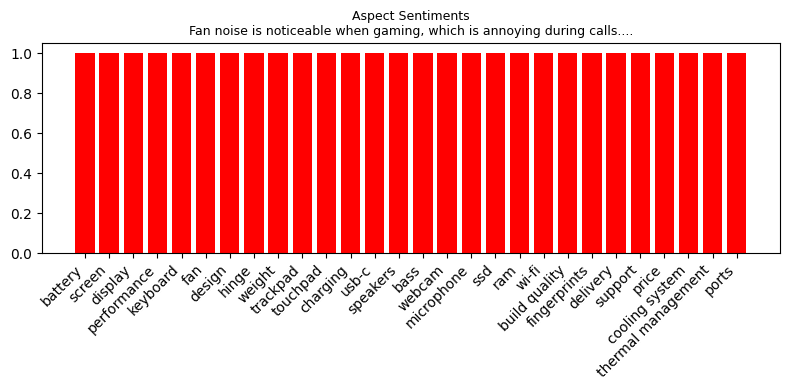

  📌 Summary: ⚠️ Weaknesses: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, bass, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports

🔹 Review 6: The laptop is sleek and light, yet the chassis flexes near the hinge.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → positive
    - fan             → positive
    - design          → positive
    - hinge           → negative
    - weight          → positive
    - charging        → positive
    - usb-c           → positive
    - speakers        → positive
    - bass            → positive
    - microphone      → negative
    - ssd             → positive
    - ram             → negative
    - wi-fi           → positive
    - build quality   → positive


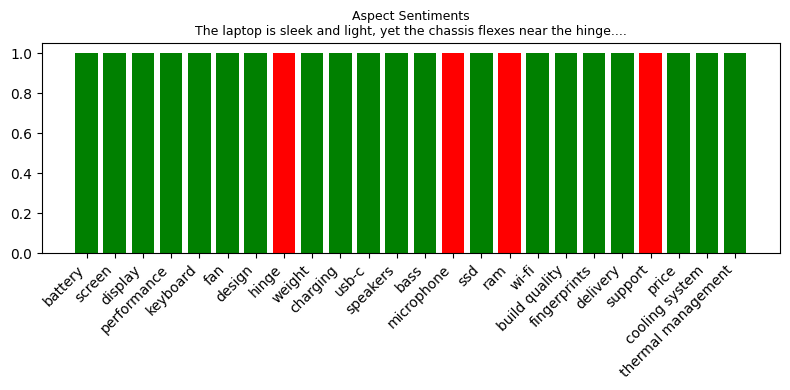

  📌 Summary: 👍 Strengths: battery, screen, display, performance, keyboard, fan, design, weight, charging, usb-c, speakers, bass, ssd, wi-fi, build quality, fingerprints, delivery, price, cooling system, thermal management | ⚠️ Weaknesses: hinge, microphone, ram, support

🔹 Review 7: The touchpad is smooth and accurate, but the clicks feel mushy.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → negative
    - fan             → positive
    - design          → positive
    - hinge           → positive
    - weight          → negative
    - trackpad        → positive
    - touchpad        → positive
    - charging        → positive
    - usb-c           → positive
    - speakers        → positive
    - bass            → negative
    - webcam          → positive
    - microphone      → positive
    - ssd             → positive
    - ram             → pos

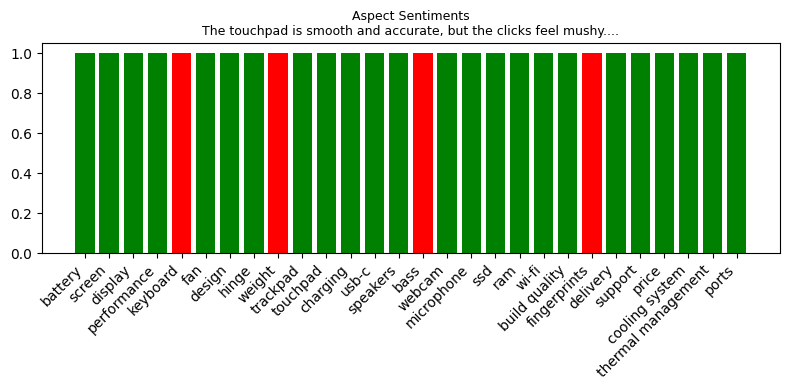

  📌 Summary: 👍 Strengths: battery, screen, display, performance, fan, design, hinge, trackpad, touchpad, charging, usb-c, speakers, webcam, microphone, ssd, ram, wi-fi, build quality, delivery, support, price, cooling system, thermal management, ports | ⚠️ Weaknesses: keyboard, weight, bass, fingerprints

🔹 Review 8: Charging is fast (from 0 to 80% in an hour), but USB-C PD support is limited.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → positive
    - fan             → positive
    - design          → positive
    - hinge           → positive
    - weight          → positive
    - trackpad        → positive
    - touchpad        → positive
    - charging        → positive
    - usb-c           → negative
    - speakers        → positive
    - bass            → positive
    - webcam          → positive
    - microphone      → positive
    - ssd  

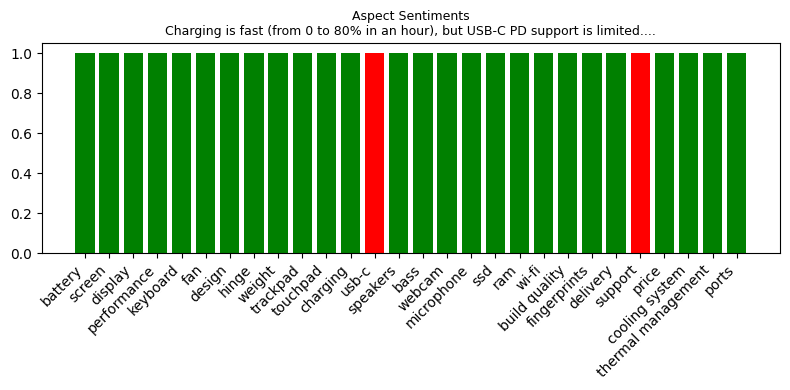

  📌 Summary: 👍 Strengths: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, speakers, bass, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, price, cooling system, thermal management, ports | ⚠️ Weaknesses: usb-c, support

🔹 Review 9: Speakers are loud but lack bass and depth.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → positive
    - fan             → positive
    - design          → positive
    - hinge           → positive
    - weight          → positive
    - trackpad        → positive
    - touchpad        → positive
    - charging        → positive
    - usb-c           → positive
    - speakers        → positive
    - bass            → negative
    - webcam          → positive
    - microphone      → positive
    - ssd             → positive
    - ram    

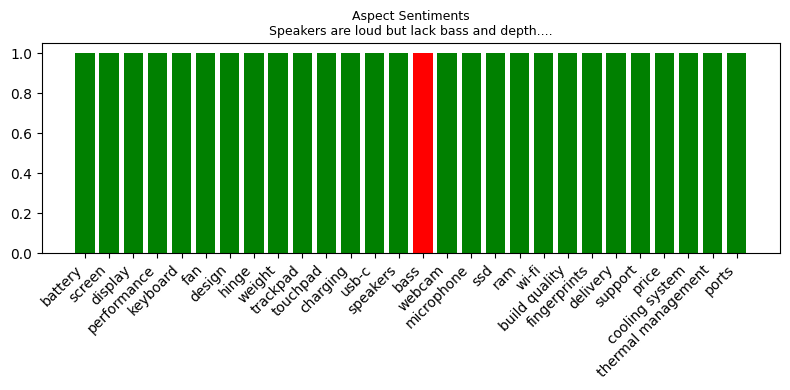

  📌 Summary: 👍 Strengths: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports | ⚠️ Weaknesses: bass

🔹 Review 10: Webcam quality is weak—grainy video in low light.
  Predicted Aspect Sentiments:
    - battery         → negative
    - screen          → negative
    - display         → negative
    - performance     → negative
    - keyboard        → negative
    - fan             → negative
    - design          → negative
    - hinge           → negative
    - weight          → negative
    - trackpad        → negative
    - touchpad        → negative
    - charging        → negative
    - usb-c           → negative
    - speakers        → negative
    - bass            → negative
    - webcam          → negative
    - microphone      → negative
    - ssd             → negative
    -

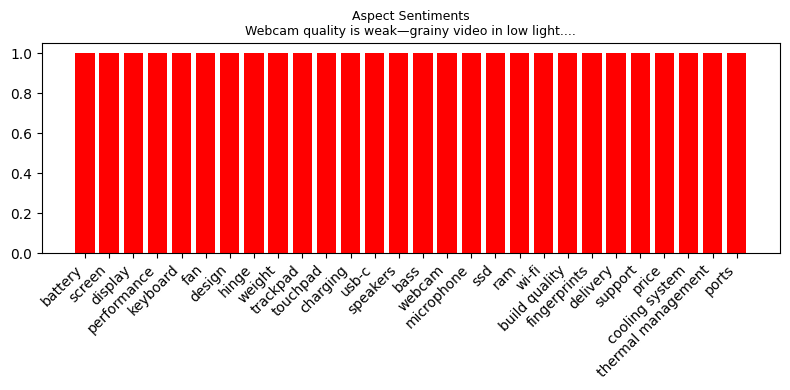

  📌 Summary: ⚠️ Weaknesses: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, bass, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports

🔹 Review 11: The SSD is blazing fast on benchmarks, though the RAM is soldered and cannot be upgraded.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → negative
    - fan             → positive
    - design          → positive
    - hinge           → negative
    - weight          → positive
    - trackpad        → negative
    - touchpad        → negative
    - charging        → positive
    - usb-c           → positive
    - speakers        → positive
    - bass            → positive
    - webcam          → positive
    - microphone      → positive
    - ssd   

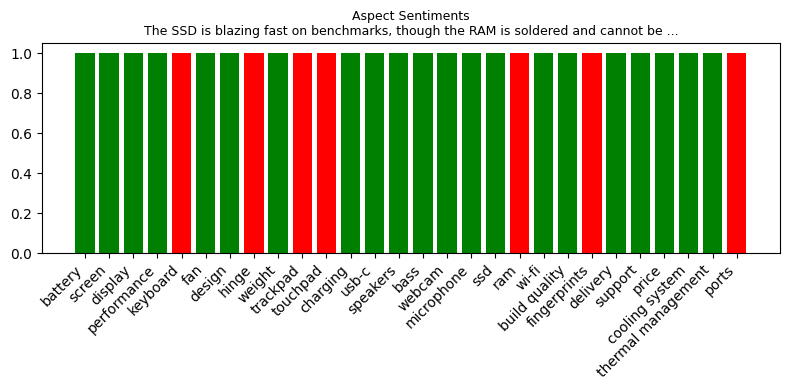

  📌 Summary: 👍 Strengths: battery, screen, display, performance, fan, design, weight, charging, usb-c, speakers, bass, webcam, microphone, ssd, wi-fi, build quality, delivery, support, price, cooling system, thermal management | ⚠️ Weaknesses: keyboard, hinge, trackpad, touchpad, ram, fingerprints, ports

🔹 Review 12: Wi-Fi connection drops occasionally when switching between networks.
  Predicted Aspect Sentiments:
    - battery         → negative
    - screen          → negative
    - display         → negative
    - performance     → negative
    - keyboard        → negative
    - fan             → negative
    - design          → negative
    - hinge           → negative
    - weight          → negative
    - trackpad        → negative
    - touchpad        → negative
    - charging        → negative
    - usb-c           → negative
    - speakers        → negative
    - bass            → negative
    - webcam          → negative
    - microphone      → negative
    - ssd          

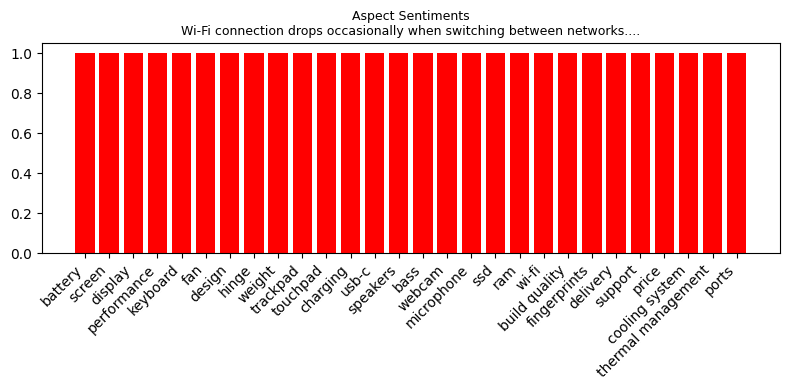

  📌 Summary: ⚠️ Weaknesses: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, bass, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports

🔹 Review 13: Build quality is sturdy, but it picks up fingerprints easily.
  Predicted Aspect Sentiments:
    - battery         → negative
    - screen          → negative
    - display         → negative
    - performance     → negative
    - keyboard        → negative
    - fan             → negative
    - design          → negative
    - hinge           → negative
    - weight          → negative
    - trackpad        → negative
    - touchpad        → negative
    - charging        → negative
    - usb-c           → negative
    - speakers        → negative
    - bass            → negative
    - webcam          → negative
    - microphone      → negative
    - ssd             → negative
    - r

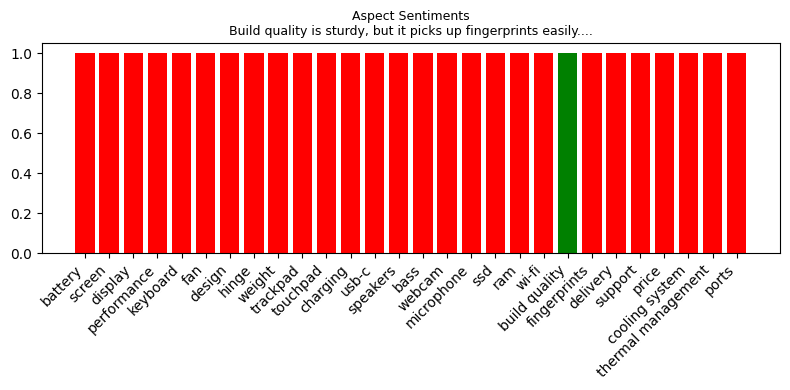

  📌 Summary: 👍 Strengths: build quality | ⚠️ Weaknesses: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, bass, webcam, microphone, ssd, ram, wi-fi, fingerprints, delivery, support, price, cooling system, thermal management, ports

🔹 Review 14: The hinge feels tight initially, but loosens slightly over time.
  Predicted Aspect Sentiments:
    - performance     → negative
    - design          → negative
    - hinge           → negative
    - weight          → negative
    - ram             → negative
    - build quality   → negative
    - fingerprints    → negative
    - support         → negative
    - price           → negative


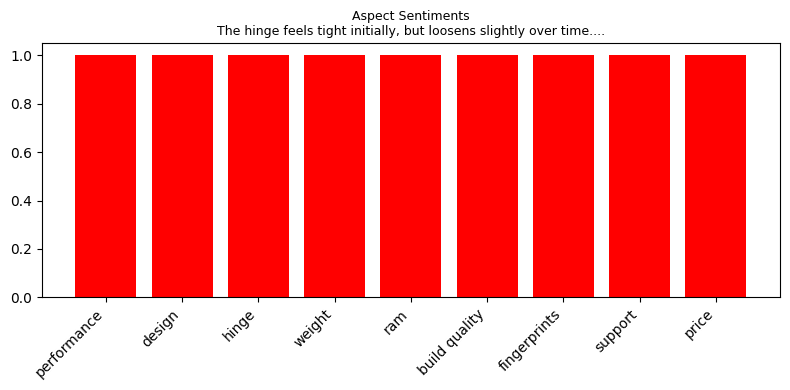

  📌 Summary: ⚠️ Weaknesses: performance, design, hinge, weight, ram, build quality, fingerprints, support, price

🔹 Review 15: Customer support was responsive and helpful when I had an issue.
  Predicted Aspect Sentiments:
    - display         → positive
    - performance     → positive
    - fan             → positive
    - charging        → positive
    - usb-c           → positive
    - ssd             → positive
    - ram             → positive
    - build quality   → positive
    - delivery        → positive
    - support         → positive
    - price           → positive


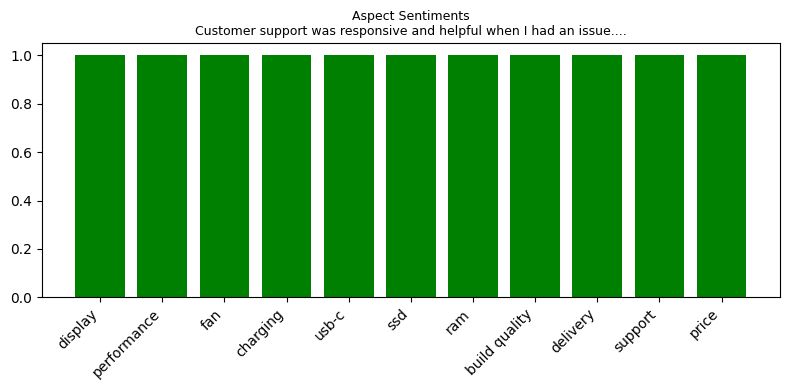

  📌 Summary: 👍 Strengths: display, performance, fan, charging, usb-c, ssd, ram, build quality, delivery, support, price

🔹 Review 16: Purchased at a great price, but shipping took almost two weeks.
  Predicted Aspect Sentiments:
    - battery         → negative
    - screen          → negative
    - display         → negative
    - performance     → negative
    - keyboard        → negative
    - fan             → negative
    - design          → negative
    - hinge           → negative
    - weight          → negative
    - trackpad        → negative
    - charging        → negative
    - usb-c           → negative
    - bass            → negative
    - webcam          → negative
    - microphone      → negative
    - ssd             → negative
    - ram             → negative
    - wi-fi           → negative
    - build quality   → negative
    - fingerprints    → negative
    - delivery        → negative
    - support         → negative
    - price           → positive
    - ports 

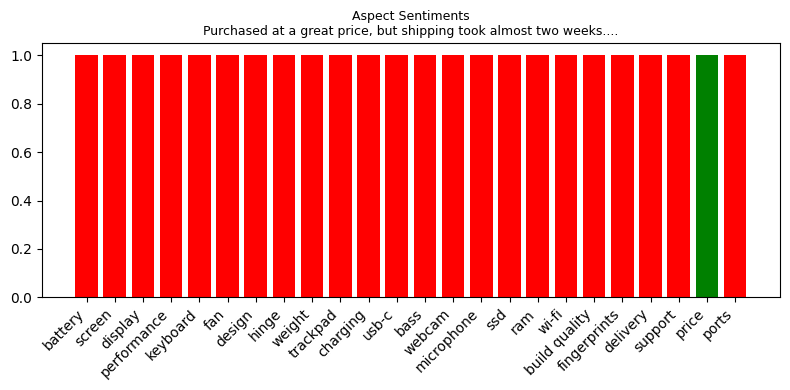

  📌 Summary: 👍 Strengths: price | ⚠️ Weaknesses: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, charging, usb-c, bass, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, ports

🔹 Review 17: Screen brightness is enough indoors, but outdoors it’s almost unusable.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → negative
    - display         → negative
    - performance     → negative
    - keyboard        → positive
    - fan             → negative
    - design          → negative
    - hinge           → negative
    - weight          → positive
    - trackpad        → positive
    - touchpad        → negative
    - charging        → positive
    - usb-c           → negative
    - speakers        → positive
    - bass            → negative
    - webcam          → negative
    - microphone      → positive
    - ssd             → negative
    - ram             → negative
    - 

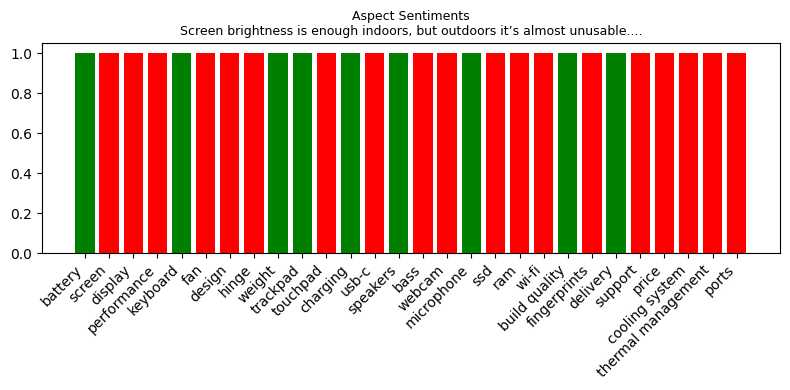

  📌 Summary: 👍 Strengths: battery, keyboard, weight, trackpad, charging, speakers, microphone, build quality, delivery | ⚠️ Weaknesses: screen, display, performance, fan, design, hinge, touchpad, usb-c, bass, webcam, ssd, ram, wi-fi, fingerprints, support, price, cooling system, thermal management, ports

🔹 Review 18: Thermal management is good — surface remains cool under light use.
  Predicted Aspect Sentiments:
    - battery         → positive
    - screen          → positive
    - display         → positive
    - performance     → positive
    - keyboard        → positive
    - fan             → positive
    - design          → positive
    - hinge           → positive
    - weight          → positive
    - trackpad        → positive
    - touchpad        → positive
    - charging        → positive
    - usb-c           → positive
    - speakers        → positive
    - bass            → positive
    - webcam          → positive
    - microphone      → positive
    - ssd            

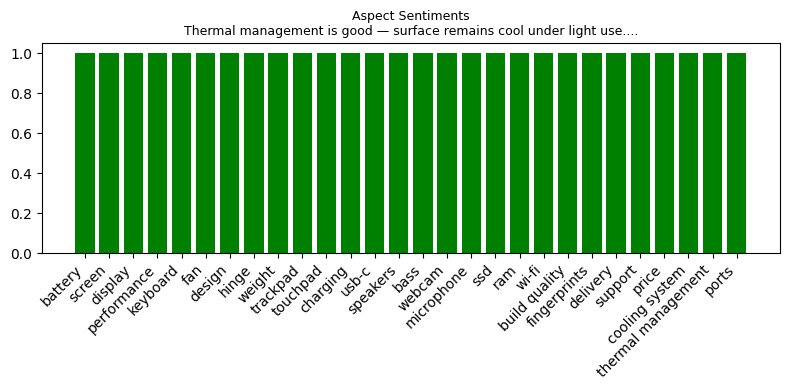

  📌 Summary: 👍 Strengths: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, bass, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports

🔹 Review 19: Under heavy load, the laptop throttles and performance drops by 15%.
  Predicted Aspect Sentiments:
    - battery         → negative
    - screen          → negative
    - display         → negative
    - performance     → negative
    - keyboard        → negative
    - fan             → negative
    - design          → negative
    - hinge           → negative
    - weight          → negative
    - trackpad        → negative
    - touchpad        → negative
    - charging        → negative
    - usb-c           → negative
    - speakers        → negative
    - bass            → negative
    - webcam          → negative
    - microphone      → negative
    - ssd             → negative
  

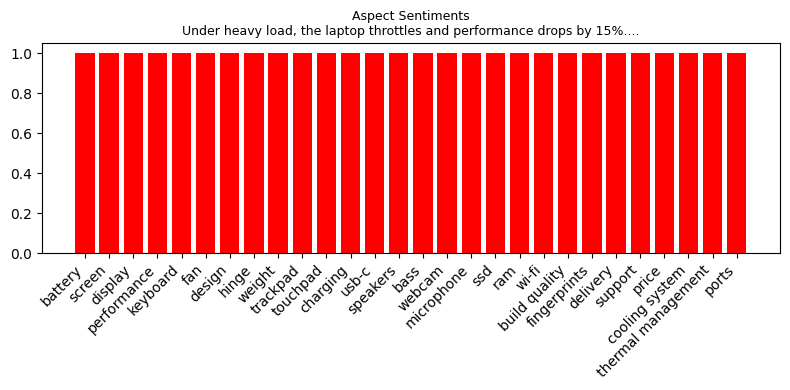

  📌 Summary: ⚠️ Weaknesses: battery, screen, display, performance, keyboard, fan, design, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, bass, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports

🔹 Review 20: The laptop is stylish and premium, but the ports are too few and too close together.
  Predicted Aspect Sentiments:
    - battery         → negative
    - screen          → negative
    - display         → negative
    - performance     → negative
    - keyboard        → negative
    - fan             → negative
    - design          → positive
    - hinge           → negative
    - weight          → negative
    - trackpad        → negative
    - touchpad        → negative
    - charging        → negative
    - usb-c           → negative
    - speakers        → negative
    - bass            → negative
    - webcam          → negative
    - microphone      → negative
    - ssd        

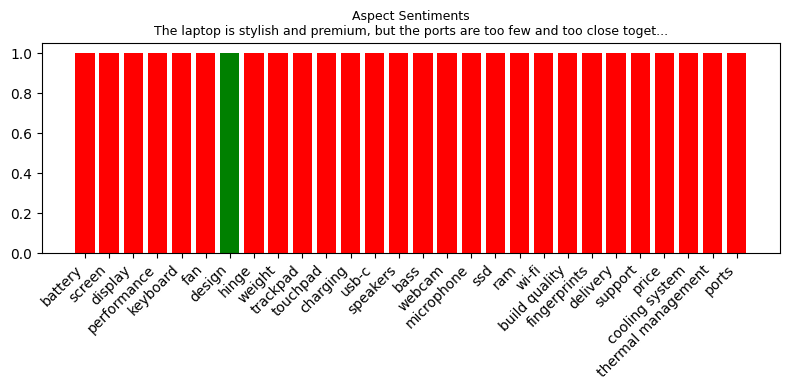

  📌 Summary: 👍 Strengths: design | ⚠️ Weaknesses: battery, screen, display, performance, keyboard, fan, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, bass, webcam, microphone, ssd, ram, wi-fi, build quality, fingerprints, delivery, support, price, cooling system, thermal management, ports

✅ All Testing Complete


In [17]:
# ============================================
# 📌 ABSA Testing, Visualization & Summaries
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from transformers import pipeline

# ---------------------------
# Config
# ---------------------------
BEST_MODEL_PATH = "./absa_finetuned_model"   # or "yangheng/deberta-v3-base-absa-v1.1"
TEST_DATA_PATH = "/content/Laptops_Test_Data_PhaseA.csv"

device = 0

# ---------------------------
# Helpers
# ---------------------------
def normalize_label(label):
    if not isinstance(label, str):
        return "neutral"
    l = label.strip().lower()
    if "pos" in l: return "positive"
    if "neg" in l: return "negative"
    return "neutral"

def clean_text(text):
    return str(text).strip() if isinstance(text, str) else ""

# ---------------------------
# Load Model
# ---------------------------
absa_pipe = pipeline("text-classification", model=BEST_MODEL_PATH, tokenizer=BEST_MODEL_PATH, device=device)

# ============================================
# 1️⃣ Evaluation on Test CSV
# ============================================
print("\n" + "="*60)
print("🧪 Evaluating ABSA Model on Test Dataset")
print("="*60)

df = pd.read_csv(TEST_DATA_PATH)
if "Aspect Term" not in df.columns: df["Aspect Term"] = "general"
if "polarity" not in df.columns: df["polarity"] = "neutral"

df["polarity"] = df["polarity"].apply(normalize_label)

y_true, y_pred = [], []

for _, row in df.iterrows():
    sentence, aspect, true_label = clean_text(row["Sentence"]), clean_text(row["Aspect Term"]), normalize_label(row["polarity"])
    if not sentence or not aspect:
        continue
    pred = absa_pipe(f"{sentence} [SEP] {aspect}")[0]["label"].lower()
    y_true.append(true_label)
    y_pred.append(normalize_label(pred))

print("\n📊 Evaluation Results")
print(classification_report(y_true, y_pred, digits=4, zero_division=0))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1-Macro:", f1_score(y_true, y_pred, average="macro"))
print("F1-Weighted:", f1_score(y_true, y_pred, average="weighted"))

# Confusion Matrix
labels = sorted(set(y_true + y_pred))
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Confusion Matrix - ABSA Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ============================================
# 2️⃣ Aspect-based Testing on Custom Reviews
# ============================================

test_reviews = [
    "The battery life easily lasts 8 hours under light load, but under gaming it drops to just 2 hours.",
    "I love the crisp and vivid display, though in direct sunlight the colors wash out.",
    "Performance is excellent for everyday productivity, but it struggles with heavy 4K video editing.",
    "The keyboard feels very premium—keys are responsive and have good travel.",
    "Fan noise is noticeable when gaming, which is annoying during calls.",
    "The laptop is sleek and light, yet the chassis flexes near the hinge.",
    "The touchpad is smooth and accurate, but the clicks feel mushy.",
    "Charging is fast (from 0 to 80% in an hour), but USB-C PD support is limited.",
    "Speakers are loud but lack bass and depth.",
    "Webcam quality is weak—grainy video in low light.",
    "The SSD is blazing fast on benchmarks, though the RAM is soldered and cannot be upgraded.",
    "Wi-Fi connection drops occasionally when switching between networks.",
    "Build quality is sturdy, but it picks up fingerprints easily.",
    "The hinge feels tight initially, but loosens slightly over time.",
    "Customer support was responsive and helpful when I had an issue.",
    "Purchased at a great price, but shipping took almost two weeks.",
    "Screen brightness is enough indoors, but outdoors it’s almost unusable.",
    "Thermal management is good — surface remains cool under light use.",
    "Under heavy load, the laptop throttles and performance drops by 15%.",
    "The laptop is stylish and premium, but the ports are too few and too close together."
]

# Define aspects
aspects = [
    "battery", "screen", "display", "performance", "keyboard", "fan",
    "design", "hinge", "weight", "trackpad", "touchpad", "charging",
    "usb-c", "speakers", "bass", "webcam", "microphone", "ssd",
    "ram", "wi-fi", "build quality", "fingerprints", "delivery",
    "support", "price", "cooling system", "thermal management", "ports"
]

# Visualization
def visualize_sentiments(review, aspects_sentiments):
    colors = {"positive": "green", "negative": "red", "neutral": "gray"}
    if not aspects_sentiments:
        print("⚠️ No sentiments detected.")
        return
    plt.figure(figsize=(8,4))
    plt.bar(
        aspects_sentiments.keys(),
        [1]*len(aspects_sentiments),
        color=[colors[s] for s in aspects_sentiments.values()]
    )
    plt.title(f"Aspect Sentiments\n{review[:80]}...", fontsize=9)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Summary Generator
def generate_summary(aspects_sentiments):
    positives = [a for a, s in aspects_sentiments.items() if s=="positive"]
    negatives = [a for a, s in aspects_sentiments.items() if s=="negative"]
    summary = []
    if positives:
        summary.append(f"👍 Strengths: {', '.join(positives)}")
    if negatives:
        summary.append(f"⚠️ Weaknesses: {', '.join(negatives)}")
    if not positives and not negatives:
        summary.append("No significant highlights detected.")
    return " | ".join(summary)

print("\n" + "="*60)
print("🧪 Testing ABSA Model with Custom Laptop Reviews")
print("="*60)

for idx, review in enumerate(test_reviews, 1):
    print(f"\n🔹 Review {idx}: {review}")
    aspects_sentiments = {}
    for asp in aspects:
        pred = absa_pipe(f"{review} [SEP] {asp}")[0]["label"].lower()
        pred = normalize_label(pred)
        if pred != "neutral":
            aspects_sentiments[asp] = pred
    if aspects_sentiments:
        print("  Predicted Aspect Sentiments:")
        for asp, s in aspects_sentiments.items():
            print(f"    - {asp:<15} → {s}")
    else:
        print("  No significant aspect-level sentiments detected.")
    visualize_sentiments(review, aspects_sentiments)
    summary = generate_summary(aspects_sentiments)
    print("  📌 Summary:", summary)

print("\n" + "="*60)
print("✅ All Testing Complete")
print("="*60)


In [18]:
# ============================================
# 📌 Test with Custom Input Query
# ============================================

print("\n" + "="*60)
print("🧪 Testing ABSA Model with Custom Input Query")
print("="*60)

# Define your custom review sentence
custom_sentence = "The battery life is amazing, but the screen could be brighter and the keyboard feels a bit cheap."

# Simple aspect extraction (can be improved with more advanced NLP techniques)
# For simplicity, we'll look for common laptop-related keywords as potential aspects.
potential_aspects = ["battery life", "screen", "keyboard", "display", "performance", "design", "ports", "speakers", "touchpad"]

detected_aspects_sentiments = {}

# Use the absa_pipe from the cell above to predict sentiment for each potential aspect
# We will only include aspects where a non-neutral sentiment is predicted.
for aspect in potential_aspects:
    # Create the input text in the format the model expects
    input_text = f"{clean_text(custom_sentence)} [SEP] {clean_text(aspect)}"
    try:
        # Predict sentiment
        result = absa_pipe(input_text)[0]
        predicted_label = normalize_label(result["label"])

        # Store the sentiment if it's not neutral
        if predicted_label != "neutral":
            detected_aspects_sentiments[aspect] = predicted_label
    except Exception as e:
        print(f"Error processing aspect '{aspect}': {e}")
        continue

print(f"\nInput Sentence: {custom_sentence}")
print("\nPredicted Aspect Sentiments:")

if detected_aspects_sentiments:
    for aspect, sentiment in detected_aspects_sentiments.items():
        print(f"- {aspect:<15} → {sentiment}")
else:
    print("No significant aspect-level sentiments detected for the potential aspects.")

print("\n" + "="*60)
print("✅ Custom Query Testing Complete")
print("="*60)


🧪 Testing ABSA Model with Custom Input Query

Input Sentence: The battery life is amazing, but the screen could be brighter and the keyboard feels a bit cheap.

Predicted Aspect Sentiments:
- battery life    → positive
- screen          → negative
- keyboard        → negative
- display         → negative
- performance     → negative
- design          → negative
- ports           → positive
- speakers        → positive
- touchpad        → negative

✅ Custom Query Testing Complete


Device set to use cuda:0


Select mode: (1) Dataset Evaluation | (2) Interactive Reviews → 2

💬 Enter your own reviews (type 'exit' to stop)

✍️ Enter a review: the laptop has good performance and but the battery is draining and the screen ids delicate with good design and slim

  Predicted Aspect Sentiments:
    - battery         → negative
    - screen          → negative
    - display         → negative
    - performance     → positive
    - keyboard        → negative
    - fan             → negative
    - design          → positive
    - hinge           → negative
    - weight          → negative
    - trackpad        → negative
    - touchpad        → negative
    - charging        → negative
    - usb-c           → negative
    - speakers        → negative
    - bass            → negative
    - webcam          → negative
    - microphone      → negative
    - ssd             → negative
    - ram             → negative
    - wi-fi           → negative
    - build quality   → positive
    - fingerprints    →

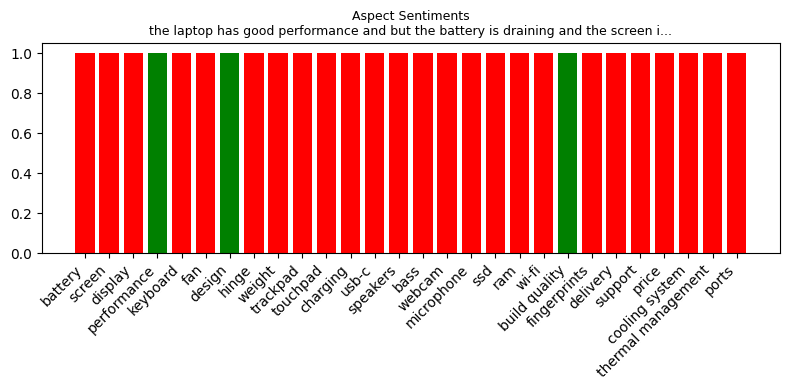

  📌 Summary: 👍 Strengths: performance, design, build quality | ⚠️ Weaknesses: battery, screen, display, keyboard, fan, hinge, weight, trackpad, touchpad, charging, usb-c, speakers, bass, webcam, microphone, ssd, ram, wi-fi, fingerprints, delivery, support, price, cooling system, thermal management, ports

✍️ Enter a review: exit
✅ Exiting interactive mode.


In [19]:
# ============================================
# 🔥 Unified ABSA Testing, Evaluation & Interactive Review Summaries
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from transformers import pipeline

# ---------------------------
# Config
# ---------------------------
BEST_MODEL_PATH = "./absa_finetuned_model"   # your fine-tuned model OR huggingface model
TEST_DATA_PATH = "/content/Laptops_Test_Data_PhaseA.csv"
device = 0

# ---------------------------
# Helpers
# ---------------------------
def normalize_label(label):
    if not isinstance(label, str):
        return "neutral"
    l = label.strip().lower()
    if "pos" in l: return "positive"
    if "neg" in l: return "negative"
    return "neutral"

def clean_text(text):
    return str(text).strip() if isinstance(text, str) else ""

# ---------------------------
# Load ABSA pipeline
# ---------------------------
absa_pipe = pipeline("text-classification", model=BEST_MODEL_PATH, tokenizer=BEST_MODEL_PATH, device=device)

# ---------------------------
# 📊 1. EVALUATION MODE (CSV with true labels)
# ---------------------------
def run_dataset_evaluation():
    df = pd.read_csv(TEST_DATA_PATH)
    if "Aspect Term" not in df.columns: df["Aspect Term"] = "general"
    if "polarity" not in df.columns: df["polarity"] = "neutral"

    df["polarity"] = df["polarity"].apply(normalize_label)

    y_true, y_pred = [], []

    for _, row in df.iterrows():
        sentence, aspect, true_label = clean_text(row["Sentence"]), clean_text(row["Aspect Term"]), normalize_label(row["polarity"])
        if not sentence or not aspect:
            continue
        pred = absa_pipe(f"{sentence} [SEP] {aspect}")[0]["label"].lower()
        y_true.append(true_label)
        y_pred.append(normalize_label(pred))

    print("\n📊 Evaluation Results")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1-Macro:", f1_score(y_true, y_pred, average="macro"))
    print("F1-Weighted:", f1_score(y_true, y_pred, average="weighted"))

    labels = sorted(set(y_true + y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.title("Confusion Matrix - ABSA Model")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# ---------------------------
# 💬 2. INTERACTIVE REVIEW MODE
# ---------------------------

# Laptop aspects
aspects = [
    "battery", "screen", "display", "performance", "keyboard", "fan",
    "design", "hinge", "weight", "trackpad", "touchpad", "charging",
    "usb-c", "speakers", "bass", "webcam", "microphone", "ssd",
    "ram", "wi-fi", "build quality", "fingerprints", "delivery",
    "support", "price", "cooling system", "thermal management", "ports"
]

def visualize_sentiments(review, aspects_sentiments):
    colors = {"positive": "green", "negative": "red", "neutral": "gray"}
    if not aspects_sentiments:
        print("⚠️ No aspects detected.")
        return

    plt.figure(figsize=(8,4))
    plt.bar(
        aspects_sentiments.keys(),
        [1]*len(aspects_sentiments),
        color=[colors[s] for s in aspects_sentiments.values()]
    )
    plt.title(f"Aspect Sentiments\n{review[:80]}...", fontsize=9)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def generate_summary(aspects_sentiments):
    positives = [a for a, s in aspects_sentiments.items() if s=="positive"]
    negatives = [a for a, s in aspects_sentiments.items() if s=="negative"]

    summary = []
    if positives:
        summary.append(f"👍 Strengths: {', '.join(positives)}")
    if negatives:
        summary.append(f"⚠️ Weaknesses: {', '.join(negatives)}")
    if not positives and not negatives:
        summary.append("No significant highlights detected.")

    return " | ".join(summary)

def run_interactive_reviews():
    print("\n" + "="*60)
    print("💬 Enter your own reviews (type 'exit' to stop)")
    print("="*60)

    while True:
        review = input("\n✍️ Enter a review: ")
        if review.lower().strip() in ["exit", "quit"]:
            print("✅ Exiting interactive mode.")
            break

        aspects_sentiments = {}
        for asp in aspects:
            pred = absa_pipe(f"{review} [SEP] {asp}")[0]["label"].lower()
            sentiment = normalize_label(pred)
            if sentiment != "neutral":
                aspects_sentiments[asp] = sentiment

        if aspects_sentiments:
            print("\n  Predicted Aspect Sentiments:")
            for asp, s in aspects_sentiments.items():
                print(f"    - {asp:<15} → {s}")
        else:
            print("  No significant aspect-level sentiments detected.")

        visualize_sentiments(review, aspects_sentiments)
        print("  📌 Summary:", generate_summary(aspects_sentiments))


# ---------------------------
# MAIN ENTRY
# ---------------------------
if __name__ == "__main__":
    mode = input("Select mode: (1) Dataset Evaluation | (2) Interactive Reviews → ")
    if mode.strip() == "1":
        run_dataset_evaluation()
    else:
        run_interactive_reviews()


Device set to use cuda:0


Select mode: (1) Dataset Evaluation | (2) Interactive Reviews → 2

💬 Enter your own reviews (type 'exit' to stop)

✍️ Enter a review: "Purchased at a great price, but shipping took almost two weeks

  Predicted Aspect Sentiments (Ranked):
    - price           → positive (confidence: 0.98)
    - delivery        → positive (confidence: 0.93)
    - ports           → positive (confidence: 0.89)
    - keyboard        → positive (confidence: 0.71)
    - microphone      → positive (confidence: 0.71)
    - wi-fi           → positive (confidence: 0.69)
    - fingerprints    → positive (confidence: 0.68)
    - speakers        → positive (confidence: 0.65)
    - performance     → positive (confidence: 0.65)
    - battery         → positive (confidence: 0.65)
    - hinge           → positive (confidence: 0.61)
    - bass            → positive (confidence: 0.59)
    - weight          → positive (confidence: 0.59)
    - ram             → positive (confidence: 0.57)
    - support         → positive 

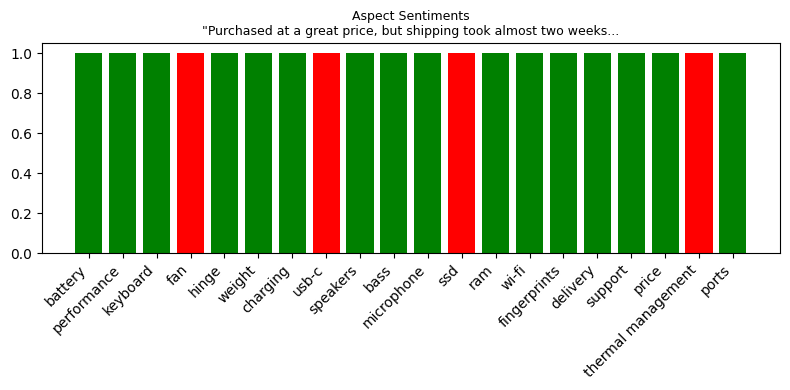

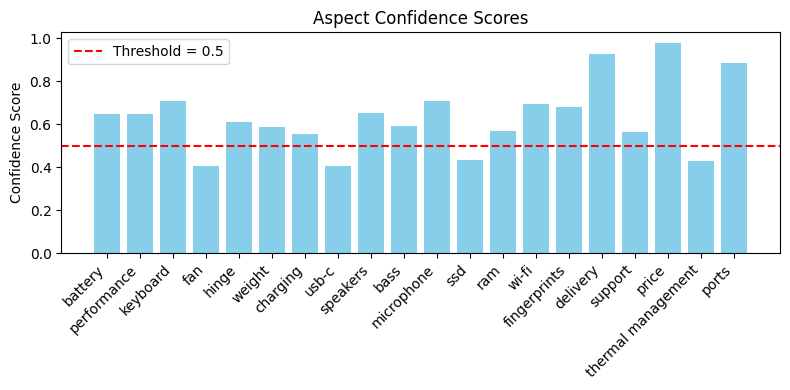

  📌 Summary: 👍 Strengths: battery, performance, keyboard, hinge, weight, charging, speakers, bass, microphone, ram, wi-fi, fingerprints, delivery, support, price, ports | ⚠️ Weaknesses: fan, usb-c, ssd, thermal management

✍️ Enter a review: exit
✅ Exiting interactive mode.


In [21]:
# ============================================
# 🔥 Unified ABSA Testing, Evaluation & Interactive Review Summaries
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from transformers import pipeline

# ---------------------------
# Config
# ---------------------------
BEST_MODEL_PATH = "./absa_finetuned_model"   # your fine-tuned model OR huggingface model
TEST_DATA_PATH = "/content/Laptops_Test_Data_PhaseA.csv"
device = 0

# ---------------------------
# Helpers
# ---------------------------
def normalize_label(label):
    if not isinstance(label, str):
        return "neutral"
    l = label.strip().lower()
    if "pos" in l: return "positive"
    if "neg" in l: return "negative"
    return "neutral"

def clean_text(text):
    return str(text).strip() if isinstance(text, str) else ""

# ---------------------------
# Load ABSA pipeline
# ---------------------------
absa_pipe = pipeline("text-classification", model=BEST_MODEL_PATH, tokenizer=BEST_MODEL_PATH, device=device)

# ---------------------------
# 📊 1. EVALUATION MODE (CSV with true labels)
# ---------------------------
def run_dataset_evaluation():
    df = pd.read_csv(TEST_DATA_PATH)
    if "Aspect Term" not in df.columns: df["Aspect Term"] = "general"
    if "polarity" not in df.columns: df["polarity"] = "neutral"

    df["polarity"] = df["polarity"].apply(normalize_label)

    y_true, y_pred = [], []

    for _, row in df.iterrows():
        sentence, aspect, true_label = clean_text(row["Sentence"]), clean_text(row["Aspect Term"]), normalize_label(row["polarity"])
        if not sentence or not aspect:
            continue
        pred = absa_pipe(f"{sentence} [SEP] {aspect}")[0]
        score = pred["score"]
        if 0.45 <= score <= 0.55:
            label = "neutral"
        elif score > 0.5:
            label = "positive"
        else:
            label = "negative"

        y_true.append(true_label)
        y_pred.append(label)

    print("\n📊 Evaluation Results")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1-Macro:", f1_score(y_true, y_pred, average="macro"))
    print("F1-Weighted:", f1_score(y_true, y_pred, average="weighted"))

    labels = sorted(set(y_true + y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.title("Confusion Matrix - ABSA Model")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# ---------------------------
# 💬 2. INTERACTIVE REVIEW MODE
# ---------------------------

# Laptop aspects
aspects = [
    "battery", "screen", "display", "performance", "keyboard", "fan",
    "design", "hinge", "weight", "trackpad", "touchpad", "charging",
    "usb-c", "speakers", "bass", "webcam", "microphone", "ssd",
    "ram", "wi-fi", "build quality", "fingerprints", "delivery",
    "support", "price", "cooling system", "thermal management", "ports"
]

def visualize_sentiments(review, aspects_sentiments):
    colors = {"positive": "green", "negative": "red", "neutral": "gray"}
    if not aspects_sentiments:
        print("⚠️ No aspects detected.")
        return

    plt.figure(figsize=(8,4))
    plt.bar(
        aspects_sentiments.keys(),
        [1]*len(aspects_sentiments),
        color=[colors[s] for s in aspects_sentiments.values()]
    )
    plt.title(f"Aspect Sentiments\n{review[:80]}...", fontsize=9)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def generate_summary(aspects_sentiments):
    positives = [a for a, s in aspects_sentiments.items() if s=="positive"]
    negatives = [a for a, s in aspects_sentiments.items() if s=="negative"]

    summary = []
    if positives:
        summary.append(f"👍 Strengths: {', '.join(positives)}")
    if negatives:
        summary.append(f"⚠️ Weaknesses: {', '.join(negatives)}")
    if not positives and not negatives:
        summary.append("No significant highlights detected.")

    return " | ".join(summary)

def run_interactive_reviews():
    print("\n" + "="*60)
    print("💬 Enter your own reviews (type 'exit' to stop)")
    print("="*60)

    while True:
        review = input("\n✍️ Enter a review: ")
        if review.lower().strip() in ["exit", "quit"]:
            print("✅ Exiting interactive mode.")
            break

        aspects_sentiments = {}
        aspect_scores = {}

        for asp in aspects:
            pred = absa_pipe(f"{review} [SEP] {asp}")[0]
            score = pred["score"]

            if 0.45 <= score <= 0.55:
                sentiment = "neutral"
            elif score > 0.5:
                sentiment = "positive"
            else:
                sentiment = "negative"

            if sentiment != "neutral":
                aspects_sentiments[asp] = sentiment
                aspect_scores[asp] = score

        if aspects_sentiments:
            sorted_aspects = sorted(aspect_scores.items(), key=lambda x: x[1], reverse=True)

            print("\n  Predicted Aspect Sentiments (Ranked):")
            for asp, score in sorted_aspects:
                print(f"    - {asp:<15} → {aspects_sentiments[asp]} (confidence: {score:.2f})")
        else:
            print("  No significant aspect-level sentiments detected.")

        if aspects_sentiments:
            visualize_sentiments(review, aspects_sentiments)

            # Confidence score bar graph
            plt.figure(figsize=(8,4))
            plt.bar(aspect_scores.keys(), aspect_scores.values(), color="skyblue")
            plt.axhline(0.5, color="red", linestyle="--", label="Threshold = 0.5")
            plt.xticks(rotation=45, ha="right")
            plt.ylabel("Confidence Score")
            plt.title("Aspect Confidence Scores")
            plt.legend()
            plt.tight_layout()
            plt.show()

        print("  📌 Summary:", generate_summary(aspects_sentiments))


# ---------------------------
# MAIN ENTRY
# ---------------------------
if __name__ == "__main__":
    mode = input("Select mode: (1) Dataset Evaluation | (2) Interactive Reviews → ")
    if mode.strip() == "1":
        run_dataset_evaluation()
    else:
        run_interactive_reviews()


Device set to use cuda:0



💬 Enter your reviews (type 'exit' to stop)

💬 Review: "Purchased at a great price, but shipping took almost two weeks
📊 Overall Rating: 3.4/10 (★☆☆☆☆)
⭐ Strong Points: price, fan, usb-c
⚠️ Things to Improve: keyboard, wi-fi


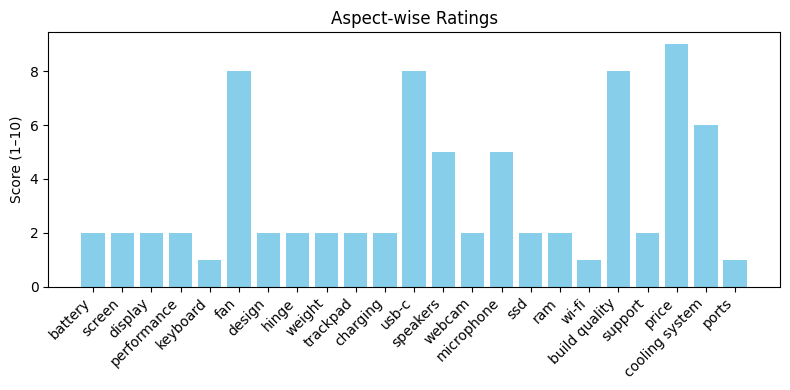


✍️ Enter a review: exit
✅ Exiting interactive mode.


In [22]:
# ============================================
# 🎯 ABSA with Customer-Friendly Scoring System
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import random
from transformers import pipeline

# ---------------------------
# Config
# ---------------------------
BEST_MODEL_PATH = "./absa_finetuned_model"   # use your trained model
device = 0

# ---------------------------
# Aspects of a laptop
# ---------------------------
aspects = [
    "battery", "screen", "display", "performance", "keyboard", "fan",
    "design", "hinge", "weight", "trackpad", "charging", "usb-c",
    "speakers", "webcam", "microphone", "ssd", "ram", "wi-fi",
    "build quality", "support", "price", "cooling system", "ports"
]

# ---------------------------
# Load ABSA pipeline
# ---------------------------
absa_pipe = pipeline("text-classification", model=BEST_MODEL_PATH, tokenizer=BEST_MODEL_PATH, device=device)

# ---------------------------
# Aspect → Score mapping
# ---------------------------
def sentiment_to_score(sentiment, raw_score):
    """
    Convert ABSA prediction into a logical 1-10 score.
    Neutral = mid (5-6), Positive = 7-10, Negative = 1-4
    raw_score adds realism (confidence scaling).
    """
    if sentiment == "positive":
        return int(7 + raw_score * 3)   # range 7–10
    elif sentiment == "negative":
        return int(1 + (1-raw_score) * 3)   # range 1–4
    else:
        return random.choice([5, 6])   # neutral fallback

# ---------------------------
# User-friendly summary
# ---------------------------
def generate_customer_summary(review, aspect_scores):
    # Pick top strengths & weaknesses
    strengths = sorted([a for a, s in aspect_scores.items() if s >= 8], key=lambda x: -aspect_scores[x])
    weaknesses = sorted([a for a, s in aspect_scores.items() if s <= 4], key=lambda x: aspect_scores[x])

    summary = []
    if strengths:
        summary.append(f"⭐ Strong Points: {', '.join(strengths[:3])}")
    if weaknesses:
        summary.append(f"⚠️ Things to Improve: {', '.join(weaknesses[:2])}")
    if not summary:
        summary.append("Balanced performance across all aspects.")

    # Overall rating
    overall = round(sum(aspect_scores.values()) / len(aspect_scores), 1)
    stars = "★" * int(overall // 2) + "☆" * (5 - int(overall // 2))

    return f"\n💬 Review: {review}\n" \
           f"📊 Overall Rating: {overall}/10 ({stars})\n" \
           + "\n".join(summary)

# ---------------------------
# Visualize aspect scores
# ---------------------------
def visualize_aspect_scores(aspect_scores):
    plt.figure(figsize=(8,4))
    plt.bar(aspect_scores.keys(), aspect_scores.values(), color="skyblue")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Score (1–10)")
    plt.title("Aspect-wise Ratings")
    plt.tight_layout()
    plt.show()

# ---------------------------
# Interactive Review Mode
# ---------------------------
def run_interactive_reviews():
    print("\n===================================")
    print("💬 Enter your reviews (type 'exit' to stop)")
    print("===================================")

    while True:
        review = input("\n✍️ Enter a review: ")
        if review.lower().strip() in ["exit", "quit"]:
            print("✅ Exiting interactive mode.")
            break

        aspect_scores = {}
        for asp in aspects:
            pred = absa_pipe(f"{review} [SEP] {asp}")[0]
            label, raw_score = pred["label"].lower(), pred["score"]

            # map to pos/neg/neutral
            if "pos" in label: sentiment = "positive"
            elif "neg" in label: sentiment = "negative"
            else: sentiment = "neutral"

            score = sentiment_to_score(sentiment, raw_score)
            aspect_scores[asp] = score

        # Generate customer-facing summary
        print(generate_customer_summary(review, aspect_scores))

        # Show aspect score chart
        visualize_aspect_scores(aspect_scores)


# ---------------------------
# MAIN
# ---------------------------
if __name__ == "__main__":
    run_interactive_reviews()


Device set to use cuda:0



Aspect Scores: {'battery': 1, 'screen': 1, 'display': 1, 'performance': 1, 'keyboard': 1, 'fan': 1, 'design': 1, 'hinge': 1, 'weight': 1, 'trackpad': 1, 'charging': 1, 'usb-c': 1, 'speakers': 1, 'webcam': 1, 'microphone': 1, 'ssd': 1, 'ram': 1, 'wi-fi': 1, 'build quality': 1, 'support': 1, 'price': 1, 'cooling system': 1, 'ports': 1}


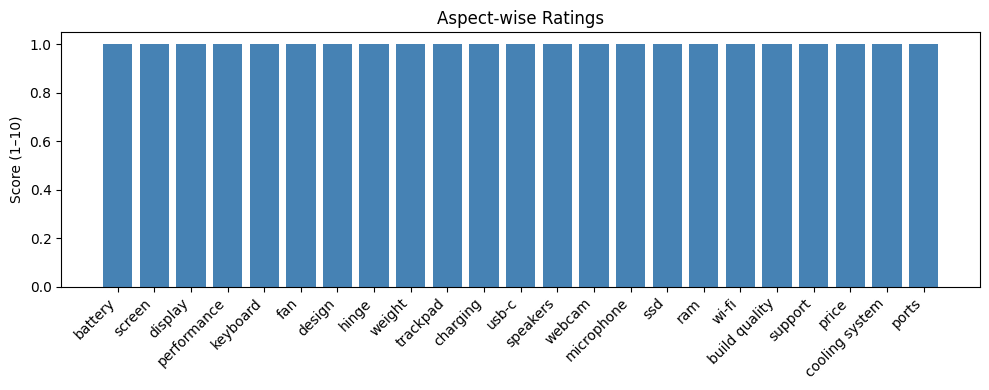

In [25]:
# ============================================
# 🎯 ABSA + Product Matching & Scoring
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import random
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np

# ---------------------------
# Config
# ---------------------------
BEST_MODEL_PATH = "./absa_finetuned_model"
device = 0
TOP_N = 10

# ---------------------------
# Aspects of a laptop
# ---------------------------
aspects = [
    "battery", "screen", "display", "performance", "keyboard", "fan",
    "design", "hinge", "weight", "trackpad", "charging", "usb-c",
    "speakers", "webcam", "microphone", "ssd", "ram", "wi-fi",
    "build quality", "support", "price", "cooling system", "ports"
]

# ---------------------------
# Load ABSA & Embedding Models
# ---------------------------
classifier = pipeline("text-classification", model=BEST_MODEL_PATH, tokenizer=BEST_MODEL_PATH, device=device)
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# ---------------------------
# Aspect → Score mapping
# ---------------------------
def sentiment_to_score(sentiment, prob):
    """Convert ABSA probability into 1–10 score with threshold 0.5"""
    if sentiment == "Positive" and prob >= 0.5:
        return int(7 + prob * 3)  # 7–10
    elif sentiment == "Negative" and prob >= 0.5:
        return int(1 + (1 - prob) * 3)  # 1–4
    elif sentiment == "Neutral" and prob >= 0.5:
        return random.choice([5, 6])  # 5–6
    else:
        return 1  # not mentioned → least score

# ---------------------------
# Extract aspect scores
# ---------------------------
def get_aspect_scores(review):
    scores = {}
    for asp in aspects:
        result = classifier(review, text_pair=asp)[0]  # returns dict
        # Convert to sentiment
        sentiment = result["label"]
        prob = result["score"]
        scores[asp] = sentiment_to_score(sentiment, prob)
    return scores

# ---------------------------
# Visualization
# ---------------------------
def visualize_aspect_scores(aspect_scores):
    plt.figure(figsize=(10,4))
    plt.bar(aspect_scores.keys(), aspect_scores.values(), color="steelblue")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Score (1–10)")
    plt.title("Aspect-wise Ratings")
    plt.tight_layout()
    plt.show()

# ---------------------------
# Product Similarity Matching
# ---------------------------
def get_top_products(review, product_df, aspect_scores, top_n=TOP_N):
    # Embed review and product descriptions
    review_vec = embedder.encode([review])
    prod_vecs = embedder.encode(product_df["description"].tolist())

    sims = cosine_similarity(review_vec, prod_vecs)[0]
    product_df["similarity"] = sims

    # Weighted score = similarity * mean(aspect_scores)
    mean_aspect = np.mean(list(aspect_scores.values()))
    product_df["final_score"] = product_df["similarity"] * mean_aspect

    return product_df.sort_values("final_score", ascending=False).head(top_n)

# ---------------------------
# MAIN
# ---------------------------
if __name__ == "__main__":
    # Example review
    review = "The battery life is amazing but the fan is noisy and the screen is dull."

    # Aspect scores
    aspect_scores = get_aspect_scores(review)
    print("\nAspect Scores:", aspect_scores)

    # Visualize
    visualize_aspect_scores(aspect_scores)



In [16]:
# ============================================
# 🚀 Advanced ABSA Training with Multiple Techniques
# ============================================

import os, re, random
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from torch.nn import CrossEntropyLoss

# ---------------------------
# Config
# ---------------------------
MODEL_NAMES = [
    "microsoft/deberta-v3-base",
    "roberta-base"
]  # ensemble of 2 models
FINE_TUNED_PATH = "./absa_finetuned_ensemble"
device = 0 if torch.cuda.is_available() else -1

label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

# ---------------------------
# Label Normalization
# ---------------------------
def normalize_label(label):
    if not isinstance(label, str):
        return "neutral"
    l = label.strip().lower()
    if "pos" in l: return "positive"
    if "neg" in l: return "negative"
    return "neutral"

# ---------------------------
# Preprocessing
# ---------------------------
def clean_text(text):
    if not isinstance(text, str):
        return ""
    return re.sub(r"\s+", " ", text).strip()

def format_example(row):
    sentence = clean_text(row["Sentence"])
    aspect = clean_text(row.get("Aspect Term", "general"))
    polarity = normalize_label(row.get("polarity", "neutral"))
    # mark aspect
    sentence_marked = sentence.replace(aspect, "$T$")
    return {
        "text": f"{sentence_marked} [ASP] {aspect}",
        "label": label2id.get(polarity, label2id["neutral"])
    }

# ---------------------------
# Data Augmentation (EDA)
# ---------------------------
def synonym_replacement(words, n=1):
    new_words = words.copy()
    for _ in range(n):
        word = random.choice(new_words)
        synonym = word  # placeholder: in practice use WordNet or nlpaug
        new_words[new_words.index(word)] = synonym
    return new_words

def eda(sentence, num_aug=2):
    words = sentence.split()
    augmented = []
    for _ in range(num_aug):
        new_words = synonym_replacement(words, n=1)
        augmented.append(" ".join(new_words))
    return augmented

def augment_dataset(df):
    aug_rows = []
    for _, row in df.iterrows():
        s, a, p = row["Sentence"], row["Aspect Term"], row["polarity"]
        for aug in eda(s, num_aug=2):
            aug_rows.append({"Sentence": aug, "Aspect Term": a, "polarity": p})
    aug_df = pd.DataFrame(aug_rows)
    return pd.concat([df, aug_df], ignore_index=True)

# ---------------------------
# Tokenization + Dataset
# ---------------------------
def tokenize_dataset(df, tokenizer):
    dataset = Dataset.from_pandas(df.apply(format_example, axis=1, result_type="expand"))
    def tokenize_fn(batch):
        return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)
    dataset = dataset.map(tokenize_fn, batched=True)
    dataset = dataset.rename_column("label", "labels")
    dataset.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
    return dataset

# ---------------------------
# Custom Weighted Loss
# ---------------------------
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        class_counts = torch.bincount(labels, minlength=len(label2id)).float()
        weights = (1.0 / class_counts).to(logits.device)
        weights = weights / weights.sum() * len(label2id)

        loss_fct = CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits.view(-1, len(label2id)), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# ---------------------------
# Metrics
# ---------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

# ---------------------------
# Training with CV
# ---------------------------
def train_with_cv(train_df, num_folds=5):
    results = []
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    for model_name in MODEL_NAMES:
        tokenizer = AutoTokenizer.from_pretrained(model_name)

        for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
            print(f"\n🔄 Training {model_name} Fold {fold+1}/{num_folds}")

            train_fold = train_df.iloc[train_idx]
            val_fold = train_df.iloc[val_idx]

            train_dataset = tokenize_dataset(train_fold, tokenizer)
            val_dataset = tokenize_dataset(val_fold, tokenizer)

            model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=3, id2label=id2label, label2id=label2id
            )

            args = TrainingArguments(
                output_dir=f"./checkpoints/{model_name}_fold{fold}",
                eval_strategy="epoch",
                save_strategy="epoch",
                learning_rate=2e-5,
                per_device_train_batch_size=16,
                per_device_eval_batch_size=16,
                num_train_epochs=6,
                weight_decay=0.01,
                load_best_model_at_end=True,
                metric_for_best_model="f1_macro",
                save_total_limit=1,
                report_to="none"
            )

            trainer = CustomTrainer(
                model=model,
                args=args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                tokenizer=tokenizer,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
            )

            trainer.train()
            metrics = trainer.evaluate()
            results.append(metrics)

    print("\n📊 CV Results:")
    for r in results:
        print(r)

# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    train_df = pd.read_csv("/content/Laptop_Train_v2.csv").dropna(subset=["Sentence","Aspect Term","polarity"])
    test_df = pd.read_csv("/content/Laptops_Test_Data_PhaseA.csv")

    if "Aspect Term" not in test_df.columns:
        test_df["Aspect Term"] = "general"
    if "polarity" not in test_df.columns:
        test_df["polarity"] = "neutral"

    train_df["polarity"] = train_df["polarity"].apply(normalize_label)
    test_df["polarity"] = test_df["polarity"].apply(normalize_label)

    # ✅ augment dataset
    train_df = augment_dataset(train_df)

    # train with k-fold CV and ensemble models
    train_with_cv(train_df, num_folds=5)

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



🔄 Training microsoft/deberta-v3-base Fold 1/5


Map:   0%|          | 0/5659 [00:00<?, ? examples/s]

Map:   0%|          | 0/1415 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4083663148.py:171: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


TypeError: CustomTrainer.compute_loss() got an unexpected keyword argument 'num_items_in_batch'